In [1]:
from skimage import io
import nibabel as nib
import os
import numpy as np
import re
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import matplotlib.pyplot as plt
import subprocess
%matplotlib inline

# Import data from cluster

In [2]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/test7/975/975ss1


In [3]:
path=foldername

In [4]:
Dataname=path.split('/')[-1]

# Open the images

In [5]:
tt = io.imread(path+'/'+Dataname+'-00010.tif') 
S=tt.shape
S

(40, 50, 104)

In [6]:
file_name_list = sorted(os.listdir(path))

Use the one below to avoid indexing problems

In [7]:
%%time
data=np.zeros([S[0],S[1],S[2],len(file_name_list)])
for i,image_file in enumerate(sorted(file_name_list)):
    #print(i)
    tt = io.imread(path+'/'+image_file)
    data[:,:,:,i]=tt[:][:][:]
    

CPU times: user 4min 26s, sys: 15.3 s, total: 4min 42s
Wall time: 4min 42s


%%time
#file_name_list = os.listdir(path)
data=np.zeros([S[0],S[1],S[2],len(file_name_list)])
i=0
for j in range(30):
#for j in range(len(file_name_list)):       
#for fn in os.listdir(path):
    tt = io.imread(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    if os.path.exists(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'):
        #print path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'
        tt = io.imread(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif')
        data[:,:,:,i]=tt[:][:][:]
        i=i+1

In [8]:
data.shape

(40, 50, 104, 12062)

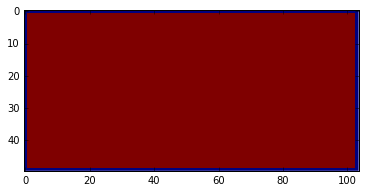

In [9]:
plt.show()
plt.imshow(data[5,:,:,10],interpolation='none')
plt.show()

In [10]:
%%time
#file_name_list = os.listdir(path)
data=np.zeros([S[0],S[1],S[2],len(file_name_list)])
i=0
#for j in range(30):
for j in range(len(file_name_list)):       
#for fn in os.listdir(path):
    #tt = io.imread(path+'/'+Dataname+'-'+str(i+1).zfill(5)+'.tif') 
    
    #if os.path.exists(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'):
    if os.path.exists(path+'/'+Dataname+'-'+str(j)+'.tif'):
        #print path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif'
        tt = io.imread(path+'/'+Dataname+'-'+str(j)+'.tif')
        #tt = io.imread(path+'/'+Dataname+'-'+str(j).zfill(5)+'.tif')
        data[:,:,:,i]=tt[:][:][:]
        i=i+1

CPU times: user 1min 9s, sys: 8.55 s, total: 1min 17s
Wall time: 1min 17s


In [8]:
data.shape


(40, 50, 104, 12062)

# Find end of onset of light and begining of offset (to align to behavior) 

Calculate average time series

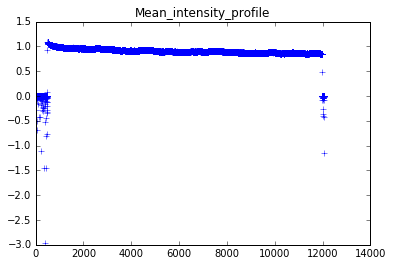

In [9]:
M=np.mean(np.mean(np.mean(data,0),0),0)
Mav=M.mean()
plt.title('Mean_intensity_profile')
plt.plot(M,'+')

### Get approximate on and off times

In [10]:
liston=[i for i in range(len(M)) if M[i]>Mav*0.8]
liston[0]

497

### Model for fitting onset and offset

In [11]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

### Model onset and find precise onset time

In [23]:
Ms=M[range(liston[0]-8,liston[0]+8)]

In [24]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [25]:
res = scipy.optimize.minimize(Sq,x0=[7,0.3,9,0.7])
ON=liston[0]-8+res.x[2]
print(ON)

497.177678708


498


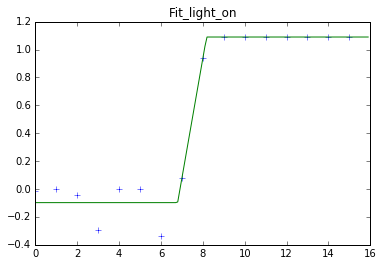

In [26]:
ONint=np.int(np.ceil(ON))
#ONint=1
print(ONint)
plt.plot(np.squeeze(M[range(liston[0]-8,liston[0]+8)]),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.title('Fit_light_on')
plt.show()

Model offset and find precise offset time

In [27]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

In [28]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [29]:
res = scipy.optimize.minimize(Sq,x0=[6,3,8,-1])

In [30]:
OFF=liston[len(liston)-1]-6+res.x[0]
OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

11974
11974


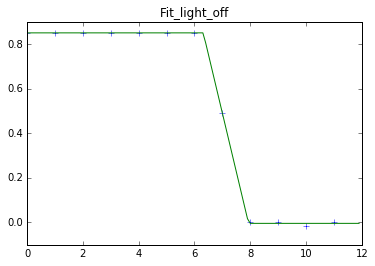

In [31]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.title('Fit_light_off')
plt.show()

In [32]:
data.shape

(40, 50, 104, 12062)

# Open images times

In [33]:
for f in os.listdir('/home/sophie/Downloads/csvs'):
    if Dataname[:6] in f:
        if f.endswith('csv'):
            TimeFile='/home/sophie/Downloads/csvs/Data'+Dataname[:6]+'_.csv'
            Listfile = open(TimeFile, 'r')
            ListTime = [line.split('\n')[0] for line in Listfile.readlines()]
            Timespl=[float(ListTime[i].split(',')[2]) for i in range(1,len(ListTime))]
        elif "Original" or "Info" in f:
            TimeFile='/home/sophie/Downloads/csvs/'+f
            with open(TimeFile, 'r') as metafile:
                lines = metafile.readlines()
            time_from_start_list = []
            for line in lines:
                if "Time_From_Start" in line:
                    split_line = line.replace('\t', ' ').replace(' = ', ' ').strip().split(' ')
                    time_from_start_list.append((int(split_line[1]),float(split_line[3])))
            Timespl = list(zip(*sorted(time_from_start_list))[1])
            

In [34]:
S

(40, 50, 104)

# Get times corresponding to images during light on (excitation light completely on : t=0)

In [35]:
print(ONint)
print(OFFint)
#print(ON)

498
11974


In [39]:
(11974-498)*0.05

573.8000000000001

In [36]:
len(Timespl)

NameError: name 'Timespl' is not defined

In [ ]:
TimeOn=[Timespl[i] for i in range(ONint,(OFFint+1))]
Tinit=(ON-(ONint-1))*(Timespl[ONint]-Timespl[ONint-1])+Timespl[ONint-1]
Toff=(OFFint+1-OFF)*(Timespl[OFFint+1]-Timespl[OFFint])+Timespl[OFFint]
Toff-Tinit

In [ ]:
Timespl[ONint]-Timespl[ONint-1]

In [ ]:
TimeOn[0]-Tinit

In [ ]:
Dataname[:6]

In [ ]:
TimeOnFinal=np.array(TimeOn)-Tinit

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TimeFluoOn.mat', {'TimeFluoOn':TimeOnFinal})

In [ ]:
TotalTimeOn=Toff-Tinit

In [ ]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TotalTimeOn.mat', {'TotalTimeOn':TotalTimeOn})

# Keep only the frames for which the excitation is on and save

In [ ]:
D4=np.transpose(data[:,:,:,range(ONint,(OFFint))],(2,1,0,3))
#D4=np.transpose(data[:,:,:,range(ONint,40000)],(2,1,0,3))
nim=nib.Nifti1Image(D4,np.eye(4))
nib.save(nim,'/media/test15/'+Dataname+'on.nii.gz')

In [ ]:
del data
del D4

# Movement Correction

In [ ]:
bashCommand = "3dvolreg -prefix "+"/media/sophie/Elements/"+Dataname+"onreg.nii "+"/mediasophie/Elements/"+Dataname+"on.nii.gz"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
import matlab.engine


In [ ]:
eng=matlab.engine.start_matlab()

In [ ]:
bashCommand = "matlab -r 'RoughAllSteps.m'"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
%matlab
RoughAllSteps